# October ??th, 2021

**Motivation**: ?? <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    
    
def get_h(pi_arr, approach='pi_animals'):
    if approach == 'pi_animals':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])
        h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h)
    proj_hr = gr.project_vec(hr)
    return h, hr, proj_h, proj_hr

In [3]:
%%time

mice = Mice((192, 4))

CPU times: user 190 ms, sys: 711 ms, total: 901 ms
Wall time: 900 ms


In [4]:
mice.setup_func_data('rest', True)

In [5]:
props = {
    'mice': mice,
    'num_k': 6,
    'perc': 'p10-sample',
    'metric': 'spearman',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'prepare_data': False,
    'verbose': False,
    'task': 'rest',
}

### Ca2

In [6]:
gr = Group(mode='ca2', centroids_from='all', **props)
group = gr.fit_group(skip_align=False)

ValueError: need at least one array to concatenate

In [ ]:
# run
pi = bn.nanmean(group['pi_run'], -3)
pi_ca_run = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_ca_run, to_vec=True)
pi_ca_run = np.concatenate([pi_ca_run, np.expand_dims(disjoint, 0)])

proj_ca_run = gr.project_vec(pi_ca_run)

# ses
pi = bn.nanmean(group['pi_ses'], -3)
pi_ca_ses = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_ca_ses, to_vec=True)
pi_ca_ses = np.concatenate([pi_ca_ses, np.expand_dims(disjoint, 0)])

proj_ca_ses = gr.project_vec(pi_ca_ses)

In [ ]:
_ = gr.show(
    proj_1=proj_ca_run, proj_2=proj_ca_ses,
    labels=('CA2 (run)', 'CA2 (ses)'),
    cmaps=('mako',) * 2,
    display=True,
)

In [7]:
sv = SVINET(**props, mode='ca2')
print(f"Ca2 symmetry score\nacross runs :\t\t{sv.pi_symmetry_score(pi_ca_run, 3)}\nacross sessions :\t{sv.pi_symmetry_score(pi_ca_ses, 3)}")


NameError: name 'pi_ca_run' is not defined

In [8]:
h, hr, proj_h, proj_hr = get_h(group['pi_run'], 'pi_animals')
_ = show_h(proj_h, proj_hr)

NameError: name 'group' is not defined

In [11]:
boot = bootstrap_scipy(
    data=group['gam_ses'],
    save_dir=tmp_dir,
    num_cuts=gr.n_cuts,
    bin_edges=gr.bin_edges,
    n_resamples=50,
    batch=5,
)

[PROGRESS] 'BCa:5.0e+01_bins(0.2,1.0;4).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [12]:
statistic = get_statistic_fn(
    axis_sub=0,
    axis_ses=1,
    axis_seed=2,
    est_sub=lambda x: x,
    est_ses=bn.nanmean,
    est_seed=bn.nanmedian,
    bins=gr.bins,
)
real_sample = statistic(group['gam_ses'])
real_sample.shape

(10, 6, 4)

In [13]:
dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(real_sample),
            'oc_idx': [i + 1] * len(real_sample),
            'color': [gr.colors[i + 1]] * len(real_sample),
            'subject': range(len(real_sample)),
            'mean': real_sample[:, i, j],
            'se': [boot['oc']['se'][i, j]] * len(real_sample),
        })
df_ca = pd.DataFrame(merge_dicts(dlist))

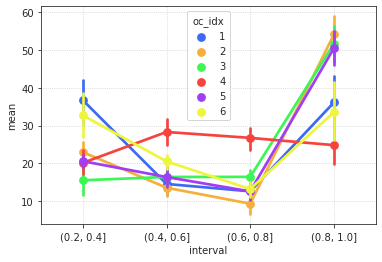

In [14]:
sns.pointplot(
    data=df_ca,
    x='interval',
    y='mean',
    hue='oc_idx',
    palette=gr.colors,
)
plt.grid()

### BOLD-Lite

In [15]:
gr = Group(mode='bold-lite', centroids_from='all', **props)
group = gr.fit_group(skip_align=False)

Warning, nan in global order

In [16]:
# run
# gam = bn.nanmedian(group['gam_run'], -3)
# pi = gam / np.nansum(gam, -2, keepdims=True)
pi = bn.nanmean(group['pi_run'], -3)
pi_bold_run = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold_run, to_vec=True)
pi_bold_run = np.concatenate([pi_bold_run, np.expand_dims(disjoint, 0)])

proj_bold_run = gr.project_vec(pi_bold_run)

# ses
# gam = bn.nanmedian(group['gam_ses'], -3)
# pi = gam / np.nansum(gam, -2, keepdims=True)
pi = bn.nanmean(group['pi_ses'], -3)
pi_bold_ses = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold_ses, to_vec=True)
pi_bold_ses = np.concatenate([pi_bold_ses, np.expand_dims(disjoint, 0)])

proj_bold_ses = gr.project_vec(pi_bold_ses)

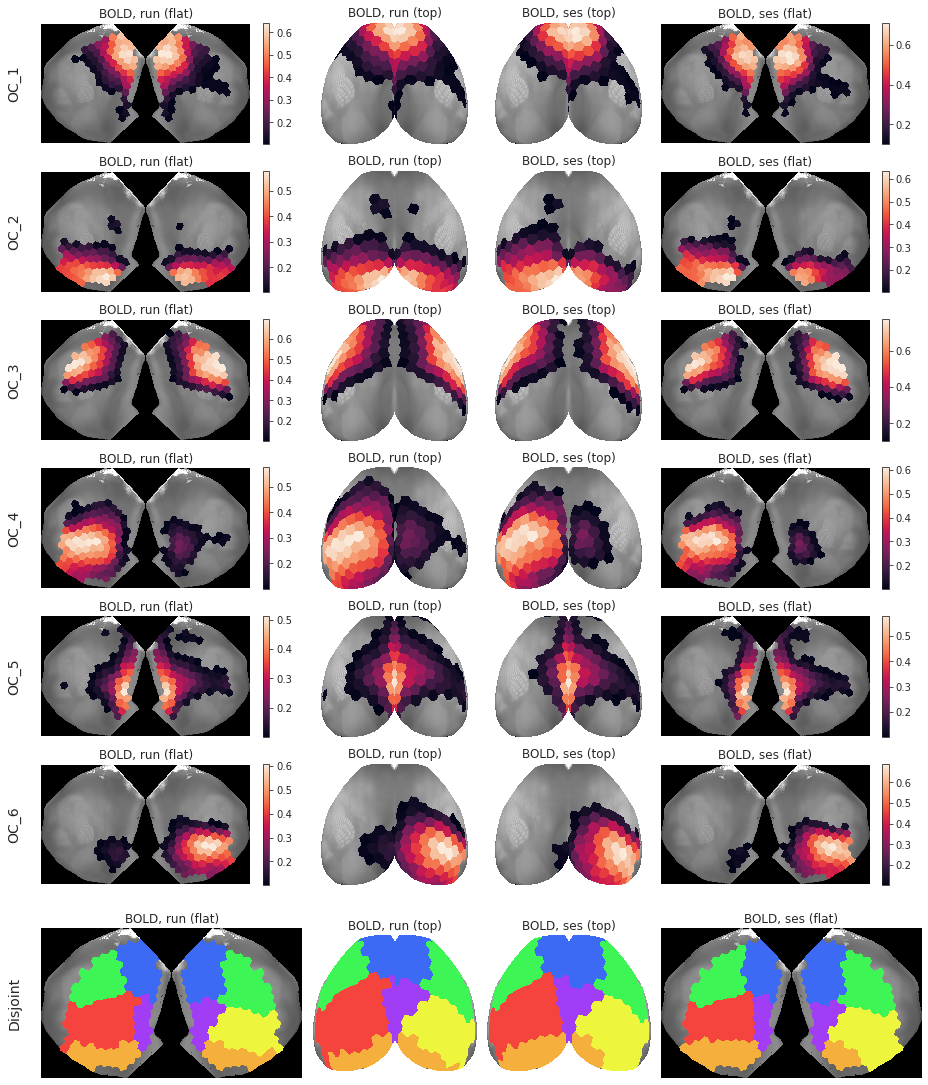

In [17]:
_ = gr.show(
    proj_1=proj_bold_run, proj_2=proj_bold_ses,
    labels=('BOLD, run', 'BOLD, ses'),
    cmaps=('rocket',) * 2,
    display=True,
)

In [18]:
sv = SVINET(**props, mode='bold-lite')
print(f"BOLD symmetry score\nacross runs :\t\t{sv.pi_symmetry_score(pi_bold_run, 3)}\nacross sessions :\t{sv.pi_symmetry_score(pi_bold_ses, 3)}")

BOLD symmetry score
across runs :           {1: 0.993, 2: 0.991, 3: 0.989, 4: 0.88, 5: 0.99, 6: 0.847, -1: 0.948}
across sessions :       {1: 0.989, 2: 0.954, 3: 0.976, 4: 0.827, 5: 0.973, 6: 0.789, -1: 
0.918}

In [19]:
boot = bootstrap_scipy(
    data=group['gam_ses'],
    save_dir=tmp_dir,
    num_cuts=gr.n_cuts,
    bin_edges=gr.bin_edges,
    n_resamples=60,
    batch=5,
)

[PROGRESS] 'BCa:6.0e+01_bins(0.2,1.0;4).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [20]:
statistic = get_statistic_fn(
    axis_sub=0,
    axis_ses=1,
    axis_seed=2,
    est_sub=lambda x: x,
    est_ses=bn.nanmean,
    est_seed=bn.nanmedian,
    bins=gr.bins,
)
real_sample = statistic(group['gam_ses'])
real_sample.shape

(10, 6, 4)

In [21]:
dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(real_sample),
            'oc_idx': [i + 1] * len(real_sample),
            'color': [gr.colors[i + 1]] * len(real_sample),
            'subject': range(len(real_sample)),
            'mean': real_sample[:, i, j],
            'se': [boot['oc']['se'][i, j]] * len(real_sample),
        })
df_bold = pd.DataFrame(merge_dicts(dlist))

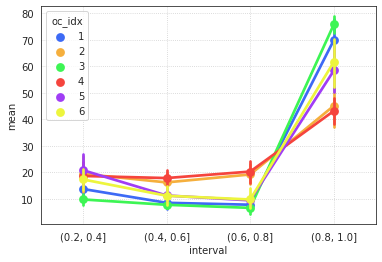

In [22]:
sns.pointplot(
    data=df_bold,
    x='interval',
    y='mean',
    hue='oc_idx',
    palette=gr.colors,
)
plt.grid()

In [23]:
boot['oc']

{
    'se': array([[2.52569949, 1.42262853, 1.10690731, 4.35403678],
       [3.38535117, 1.89961714, 1.7527882 , 4.19676757],
       [0.94055317, 0.75816566, 1.56989669, 1.93615191],
       [2.62161333, 1.46871991, 2.15260203, 2.58140242],
       [2.78102745, 1.15220932, 1.0647096 , 4.26709352],
       [2.15602056, 1.88262947, 1.78024514, 4.85619425]]),
    'ci_low': array([[ 9.33108647,  5.18641778,  5.37129141, 61.60263885],
       [13.48456867, 12.17305409, 16.11280456, 33.68728714],
       [ 7.60111203,  5.93624958,  3.8372342 , 72.2937611 ],
       [12.81947141, 15.13293389, 16.22615161, 37.70712076],
       [14.50557501,  7.91674718,  7.67071221, 50.1730809 ],
       [13.10148663,  7.53096216,  6.01864996, 51.06551679]]),
    'ci_high': array([[18.88118773, 11.36842777, 10.01148131, 82.20067556],
       [28.6664544 , 19.95324577, 24.24227511, 53.30024426],
       [11.77455958,  9.4046232 ,  9.85820032, 79.6047547 ],
       [24.45259597, 21.24184497, 25.50650101, 48.90305499],
       [26.56052711, 13.15516595, 11.81614025, 70.45268358],
       [20.92229773, 15.29261341, 13.90087428, 71.20719878]])
}

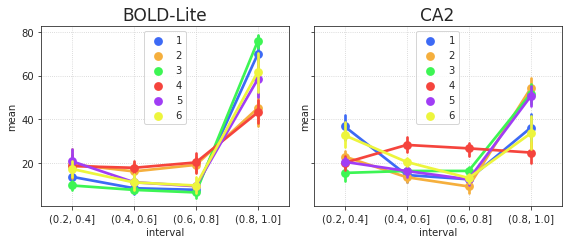

In [24]:
fig, axes = create_figure(1, 2, (8, 3.5), 'all', 'all')

sns.pointplot(
    data=df_bold,
    x='interval',
    y='mean',
    hue='oc_idx',
    palette=gr.colors,
    ax=axes[0],
)
axes[0].set_title('BOLD-Lite', fontsize=17)

sns.pointplot(
    data=df_ca,
    x='interval',
    y='mean',
    hue='oc_idx',
    palette=gr.colors,
    ax=axes[1],
)
axes[1].set_title('CA2', fontsize=17)

for ax in axes.flat:
    ax.legend(loc='upper center')
    ax.grid()
fig.savefig(pjoin(tmp_dir, 'distributions.pdf'), bbox_inches='tight')
plt.show()

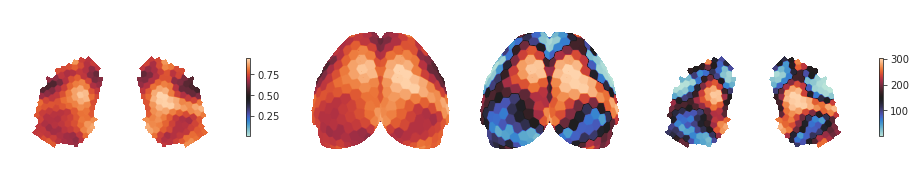

In [25]:
h, hr, proj_h, proj_hr = get_h(group['pi_run'], 'pi_animals')
_ = show_h(proj_h, proj_hr)

In [26]:
fig, _ = gr.show(
    proj_bold_run, proj_ca_run,
    labels=('BOLD-Lite', 'CA2'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"k{props.get('num_k')} / {props.get('perc')}"
sup = fig.suptitle(sup, fontsize=20, y=1.02)

In [27]:
fig.savefig(
    pjoin(tmp_dir, 'communities_svinet.pdf'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
)
fig.savefig(
    pjoin(tmp_dir, 'communities_svinet.png'),
    bbox_extra_artists=[sup],
    bbox_inches='tight', 
    dpi=200,
)

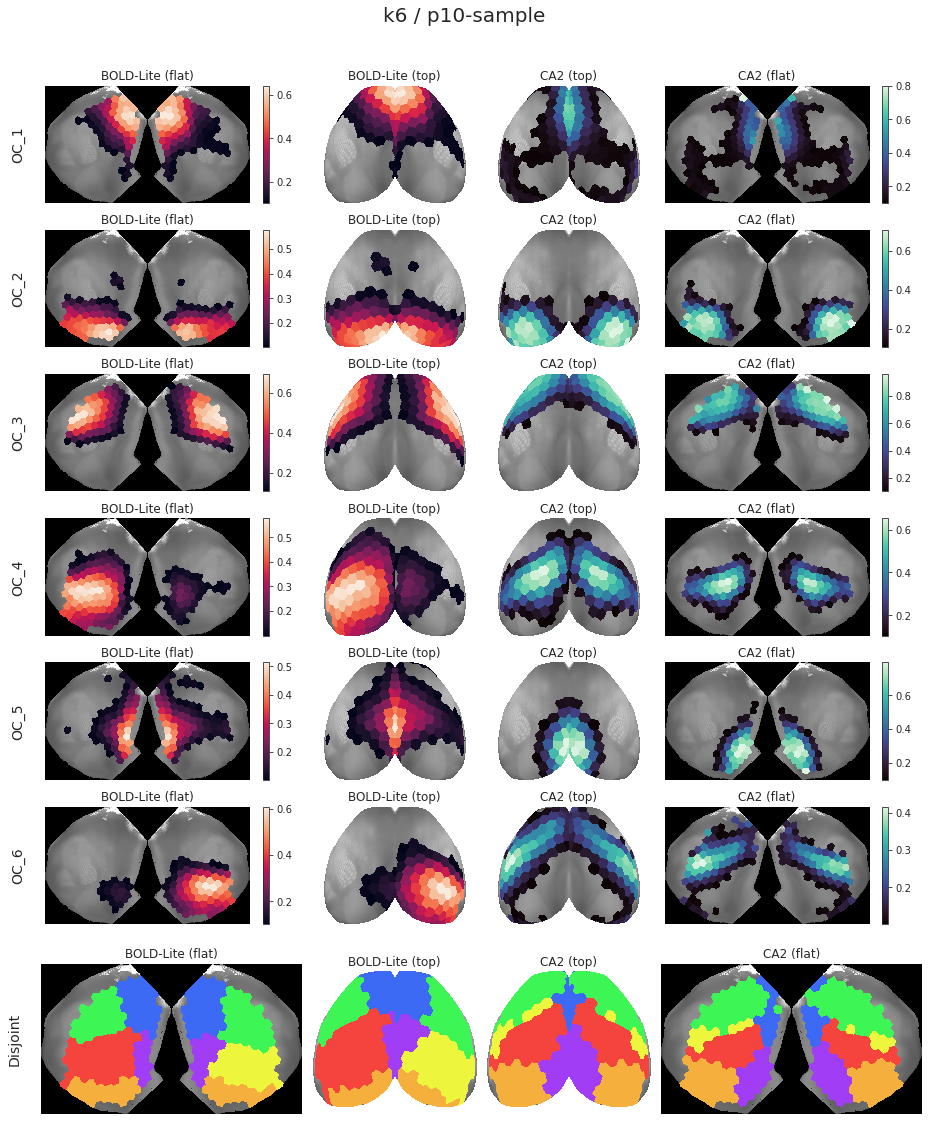

In [28]:
fig

In [9]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.988, 2: 0.984, 3: 0.99, 4: 0.984, 5: 0.978, -1: 0.985}

In [76]:
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=False)

Warning, nan in global order

In [77]:
pi = bn.nanmean(pi_arr, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

pi_ca.shape

(6, 302)

In [78]:
proj_ca = gr.project_vec(pi_ca)

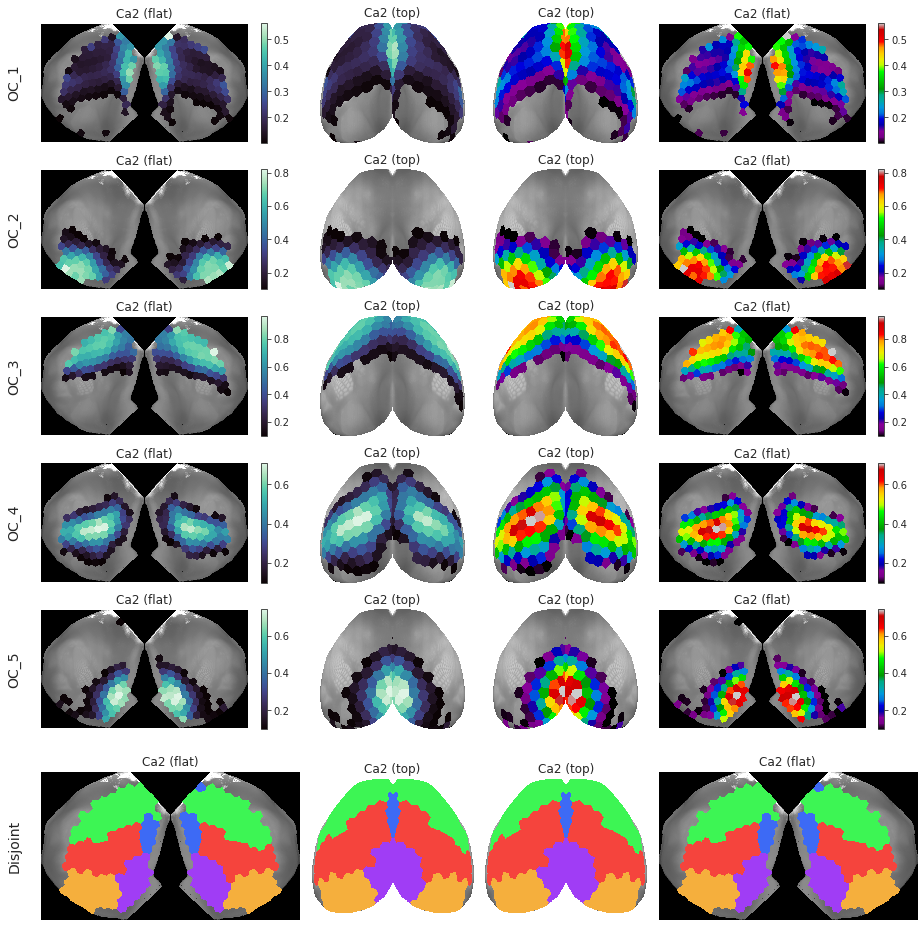

In [79]:
gr.show(proj_ca, labels=('Ca2',) * 2, cmaps=('mako', 'nipy_spectral'))

In [80]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.984, 2: 0.986, 3: 0.992, 4: 0.991, 5: 0.985, -1: 0.987}

<AxesSubplot:ylabel='Count'>

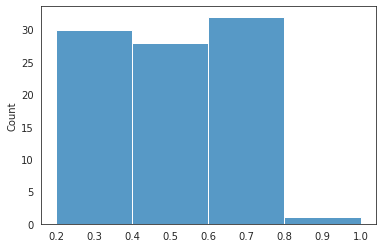

In [81]:
sns.histplot(pi_ca[4], bins=np.linspace(0.2, 1.0, 5))

In [82]:
pi = bn.nanmean(pi_arr, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
pi_ca.shape

(5, 302)

In [83]:
h = sp_stats.entropy(pi_ca, axis=0) / np.log(len(pi_ca))

In [84]:
proj_h = gr.project_vec(h)

<matplotlib.colorbar.Colorbar object at 0x7f110e1cf9a0>

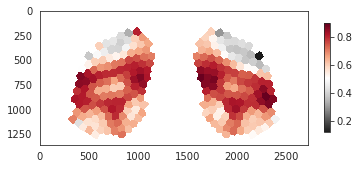

In [85]:
x2plt = proj_h['parcel2d-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.5)

<matplotlib.colorbar.Colorbar object at 0x7f1197f43eb0>

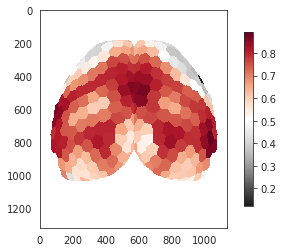

In [86]:
x2plt = proj_h['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.8)

In [87]:
pi_arr.shape

(10, 3, 4, 1000, 5, 302)

In [88]:
h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])

In [89]:
h = np.nanmean(np.nanmean(np.nanmean(np.nanmean(h_arr, -2), 2), 1), 0)
h.shape, h_arr.shape

((302,), (10, 3, 4, 1000, 302))

In [90]:
proj_h = gr.project_vec(h)

<matplotlib.colorbar.Colorbar object at 0x7f11af244430>

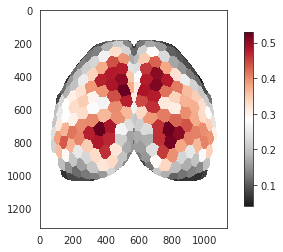

In [91]:
x2plt = proj_h['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.8)

<matplotlib.colorbar.Colorbar object at 0x7f10fcaaf910>

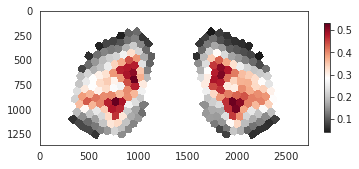

In [92]:
x2plt = proj_h['parcel2d-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.5)

<AxesSubplot:ylabel='Count'>

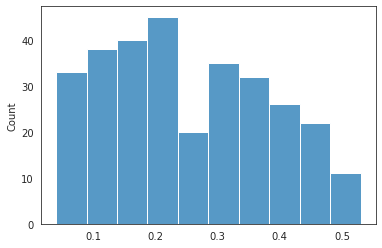

In [93]:
sns.histplot(h)

In [94]:
np.quantile(h, [0.25, 0.5, 0.75])

array([0.14422146, 0.23137912, 0.35681387])

<matplotlib.colorbar.Colorbar object at 0x7f119ee05370>

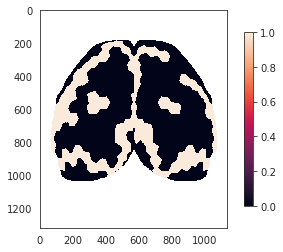

In [111]:
x2plt = proj_h['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(np.logical_and(x2plt > np.quantile(h, 0.33), x2plt < np.quantile(h, 0.66)))
plt.colorbar(shrink=0.8)

In [131]:
h_vol = np.zeros(mice.parcel['cortex'].shape)

obj_idxs = pd.DataFrame(mice.parcel['cortex'].flat)
obj_idxs = obj_idxs.groupby([0]).indices

for ii, ids in obj_idxs.items():
    if ii == 0:
        continue
    hcl = mice.parcel.decode(int(ii))
    lr, cc, ll = hcl.flat
    node = gr.l2n.get(f"{lr}-{cc}-{ll}")
    if node is not None:
        h_vol.flat[ids] = h[node]
h_vol.shape

(132, 80, 114)

<matplotlib.colorbar.Colorbar object at 0x7f11b10a58b0>

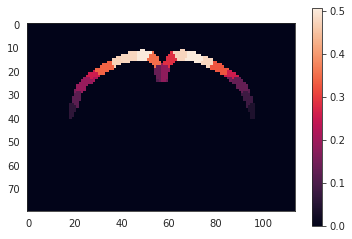

In [160]:
plt.imshow(h_vol[40])
plt.colorbar()

In [27]:
pi_anim = bn.nanmean(bn.nanmean(pi, 2), 1)
pi_anim.shape

(10, 5, 302)

In [28]:
pi_test = pi_anim[1]

In [29]:
disjoint = gr.get_disjoint_community(pi_test, to_vec=True)
pi_test = np.concatenate([pi_test, np.expand_dims(disjoint, 0)])

In [40]:
_proj = gr.project_vec(pi_test)

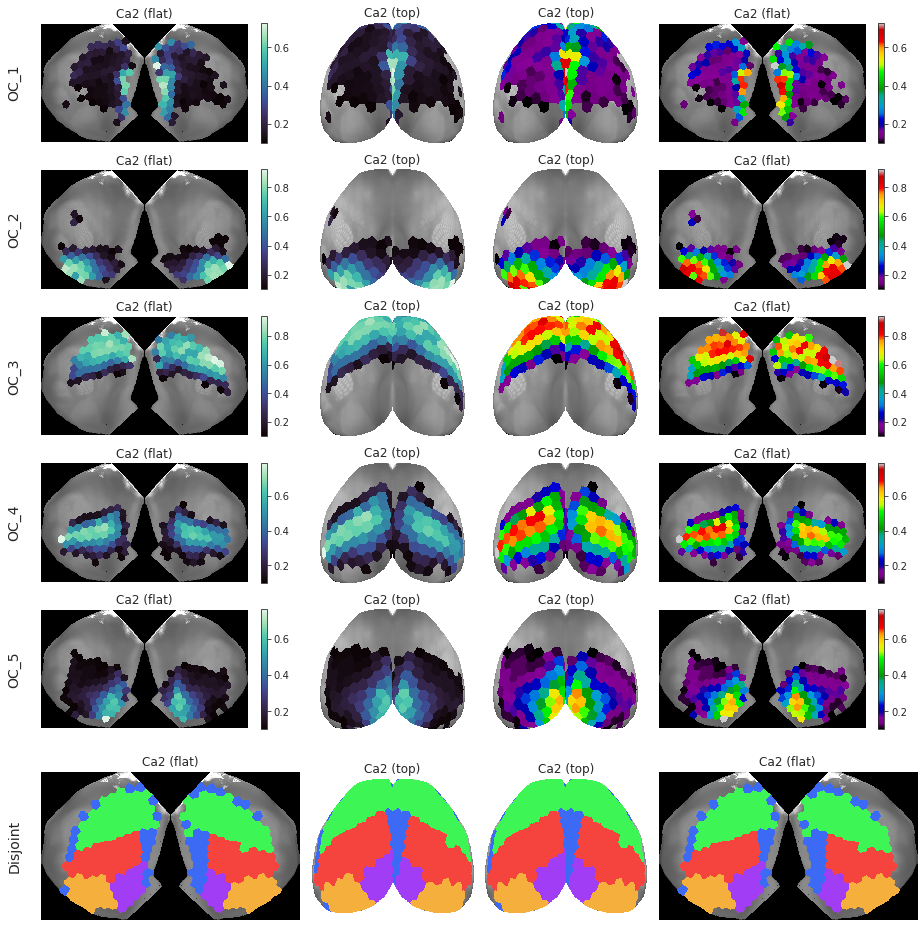

In [41]:
gr.show(_proj, labels=('Ca2',) * 2, cmaps=('mako', 'nipy_spectral'))

In [42]:
props = {
    'mice': mice,
    'num_k': 5,
    'perc': 'p15-sample',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'prepare_data': False,
    'verbose': False,
}

In [43]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=True)

In [44]:
pi = bn.nanmean(pi_arr, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

pi_bold.shape

(6, 302)

In [45]:
proj_bold = gr.project_vec(pi_bold)

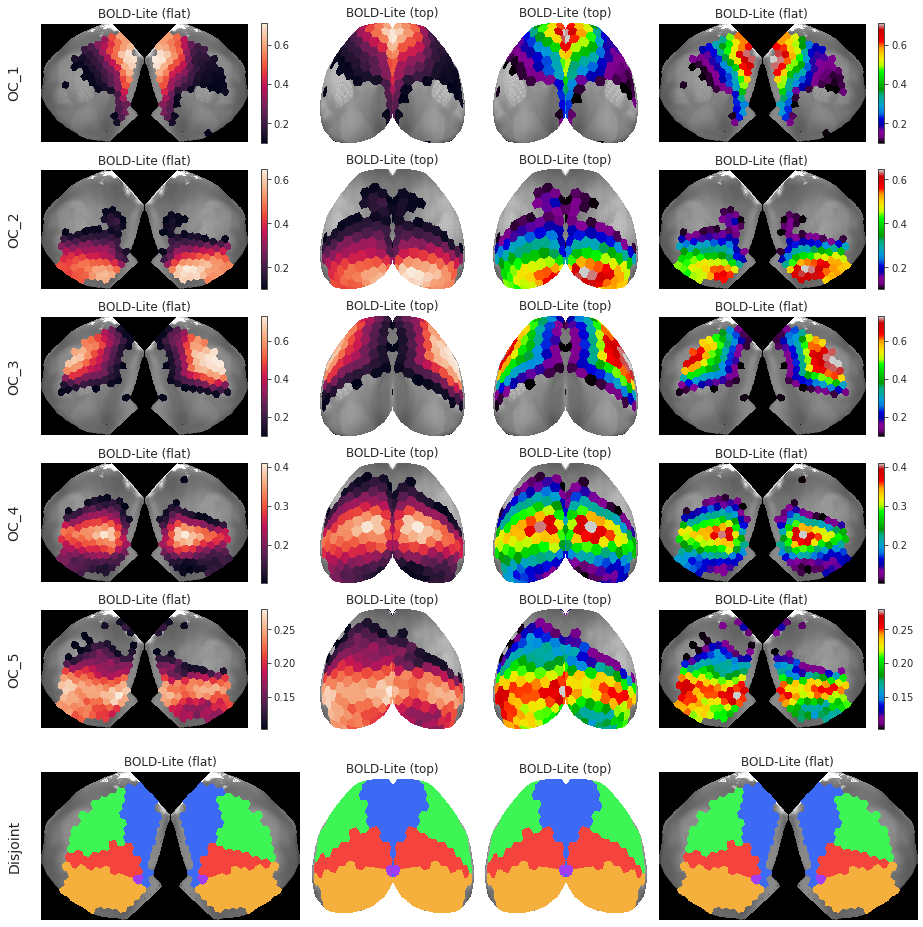

In [46]:
gr.show(proj_bold, labels=('BOLD-Lite',) * 2, cmaps=('rocket', 'nipy_spectral'))

In [48]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_bold, 3)

{1: 0.995, 2: 0.994, 3: 0.986, 4: 0.988, 5: 0.987, -1: 0.99}

In [49]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=False)

Warning, nan in global order

In [50]:
pi = bn.nanmean(pi_arr, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

pi_bold.shape

(6, 302)

In [51]:
proj_bold = gr.project_vec(pi_bold)

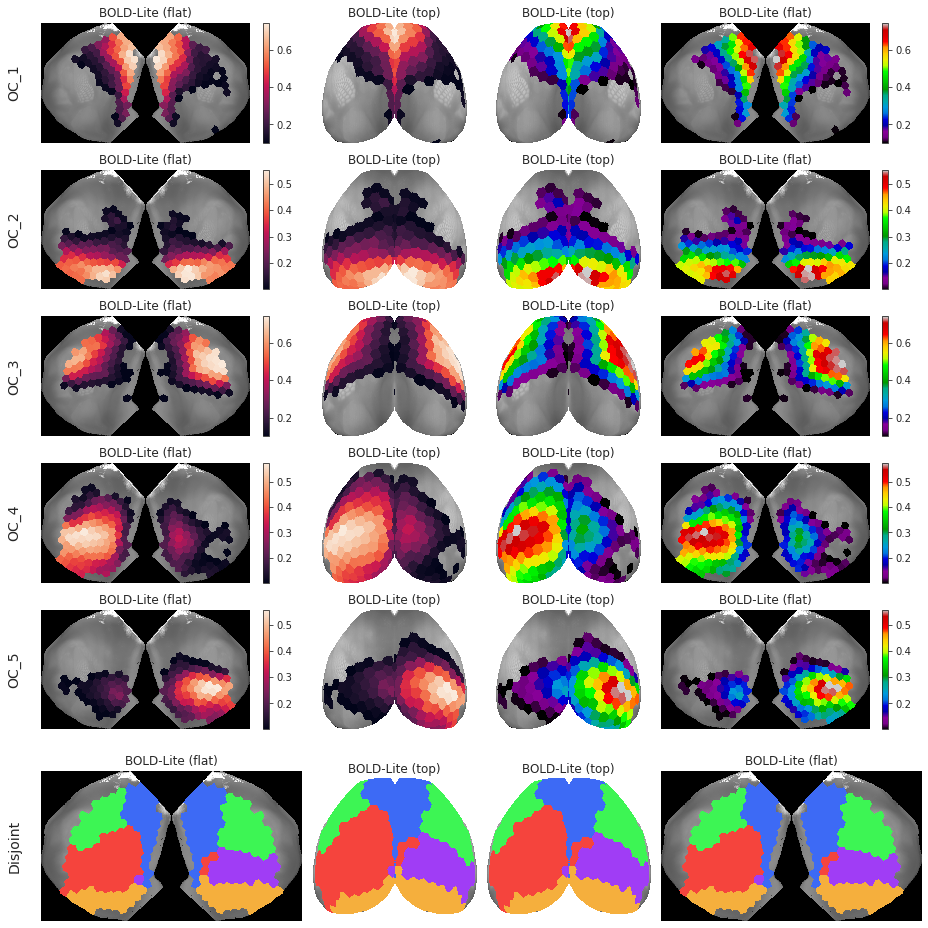

In [52]:
gr.show(proj_bold, labels=('BOLD-Lite',) * 2, cmaps=('rocket', 'nipy_spectral'))

In [53]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_bold, 3)

{1: 0.994, 2: 0.995, 3: 0.982, 4: 0.888, 5: 0.891, -1: 0.95}

<AxesSubplot:ylabel='Count'>

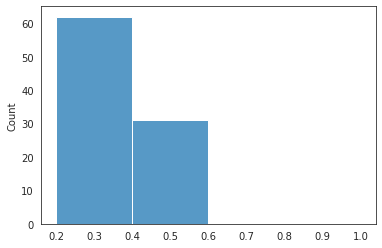

In [59]:
sns.histplot(pi_bold[4], bins=np.linspace(0.2, 1.0, 5))

In [60]:
pi = bn.nanmean(pi_arr, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
pi_bold.shape

(5, 302)

In [61]:
h = sp_stats.entropy(pi_bold, axis=0) / np.log(len(pi_bold))

In [62]:
proj_h = gr.project_vec(h)

<matplotlib.colorbar.Colorbar object at 0x7f11abb876d0>

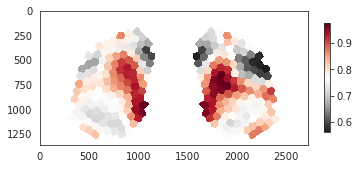

In [63]:
x2plt = proj_h['parcel2d-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.5)

<matplotlib.colorbar.Colorbar object at 0x7f11b2e43940>

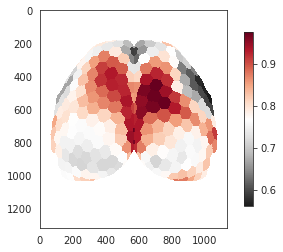

In [64]:
x2plt = proj_h['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.8)

In [65]:
pi_arr.shape

(10, 3, 4, 1000, 5, 302)

In [66]:
h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])

In [67]:
h = np.nanmean(np.nanmean(np.nanmean(np.nanmean(h_arr, -2), 2), 1), 0)
h.shape, h_arr.shape

((302,), (10, 3, 4, 1000, 302))

In [68]:
proj_h = gr.project_vec(h)

<matplotlib.colorbar.Colorbar object at 0x7f1197c56d00>

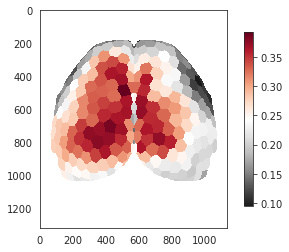

In [69]:
x2plt = proj_h['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.8)

<matplotlib.colorbar.Colorbar object at 0x7f11a47c07f0>

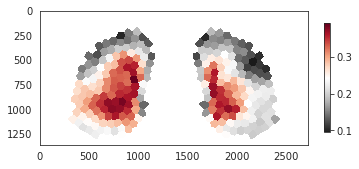

In [70]:
x2plt = proj_h['parcel2d-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(x2plt, cmap='RdGy_r')
plt.colorbar(shrink=0.5)

<matplotlib.colorbar.Colorbar object at 0x7fc34c761670>

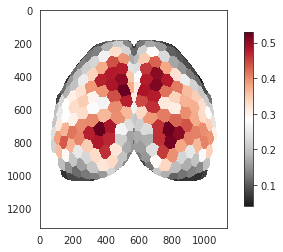

<matplotlib.colorbar.Colorbar object at 0x7fc34bf76640>

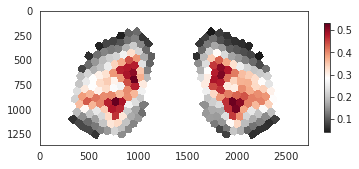

In [71]:
pi_anim = bn.nanmean(bn.nanmean(pi, 2), 1)
pi_anim.shape

(10, 5, 302)

In [72]:
pi_test = pi_anim[1]

In [73]:
disjoint = gr.get_disjoint_community(pi_test, to_vec=True)
pi_test = np.concatenate([pi_test, np.expand_dims(disjoint, 0)])

In [74]:
_proj = gr.project_vec(pi_test)

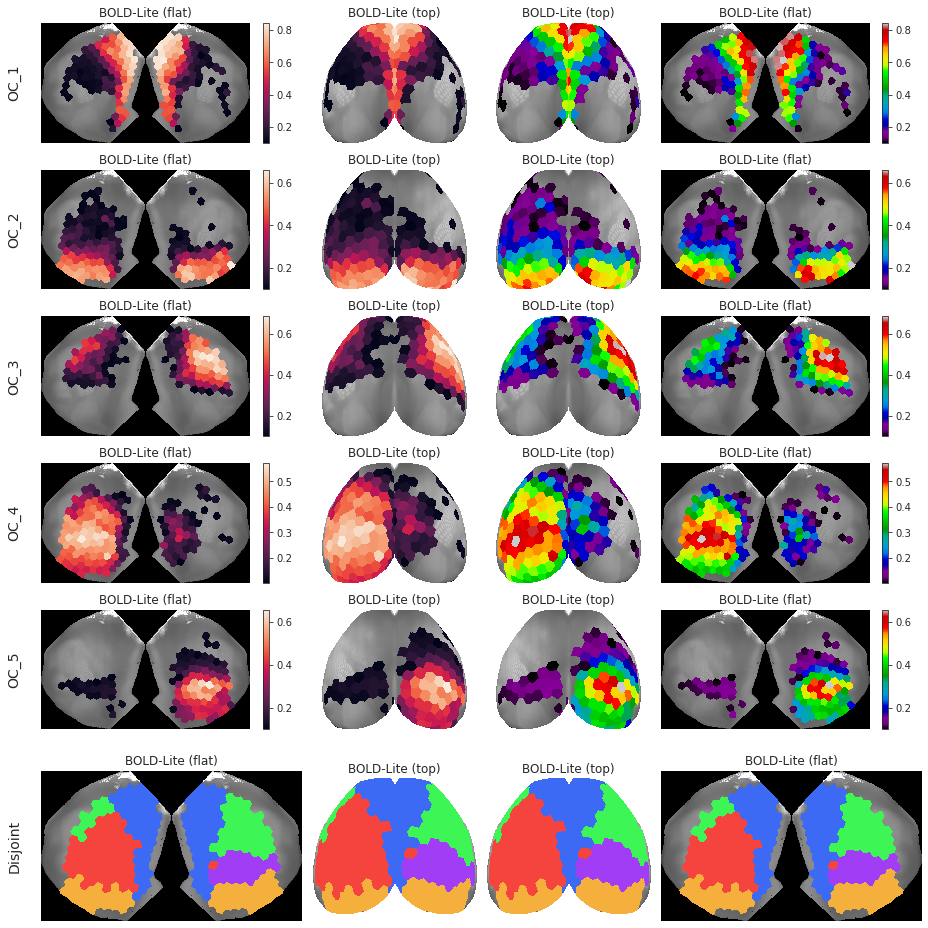

In [75]:
gr.show(_proj, labels=('BOLD-Lite',) * 2, cmaps=('rocket', 'nipy_spectral'))

In [ ]:


for path in tqdm(pathlib.Path(mice.cfg.svinet_dir).rglob(r"p[0-9]*")):


0it [00:00, ?it/s]

In [30]:
import fnmatch

paths = pathlib.Path(mice.cfg.svinet_dir)
run_counts = collections.defaultdict(dict)

In [32]:
for path in tqdm(paths.rglob(f"*{gr.base_name}*/**/p[0-9]*/")):
    if path.name.endswith('txt'):
        continue
    name = next(e for e in str(path).split('/') if '_sub-' in e)
    count = len(fnmatch.filter(os.listdir(path), r"*-mmsb-seed[0-9]*"))
    run_counts[gr.base_name][path.name] = count

0it [00:00, ?it/s]

In [33]:
run_counts

defaultdict(<class 'dict'>, {
    'n-192*4_bold-lite_rest_pearson_sub-SLC': {
        'p10-sample': 0,
        'p20-sample': 0,
        'p30-binary': 0,
        'p5-binary': 0,
        'p15-binary': 0,
        'p20-binary': 0,
        'p15-sample': 1000,
        'p5-sample': 0,
        'p30-sample': 0,
        'p10-binary': 0,
        'p40-binary': 1000,
        'p40-sample': 1000
    }
})

In [4]:
structs2align = [
    ['ACA', 'MOs'],
    ['VISp', 'VISpm'],
    ['SSp-m', 'SSs', 'MOp'],
    ['SSp-ll', 'SSp-tr'],
    ['ECT', 'PERI', 'TEa'],
    ['AId', 'AIv'],
]

gr = Group(mice, 5, 'p15-sample', 'bold-lite', centroids_from='all')#, structs2align=structs2align)

In [5]:
pi_arr, gam_arr, lam_arr = gr.fit_group()

Warning, nan in global order

In [6]:
__pi, gam, lam = tuple(map(
    lambda x: bn.nanmedian(x, -3),
    [pi_arr, gam_arr, lam_arr]
))

pi = gam / np.nansum(gam, -2, keepdims=True)
pi.shape

(10, 3, 4, 5, 302)

In [7]:
__pi_avg, pi_avg, gam_avg, lam_avg = tuple(map(
    lambda x: bn.nanmean(bn.nanmean(bn.nanmean(x, 2), 1), 0),
    [__pi, pi, gam, lam]
))

In [8]:
pi_avg.shape, np.isnan(pi_avg).sum()

((5, 302), 0)

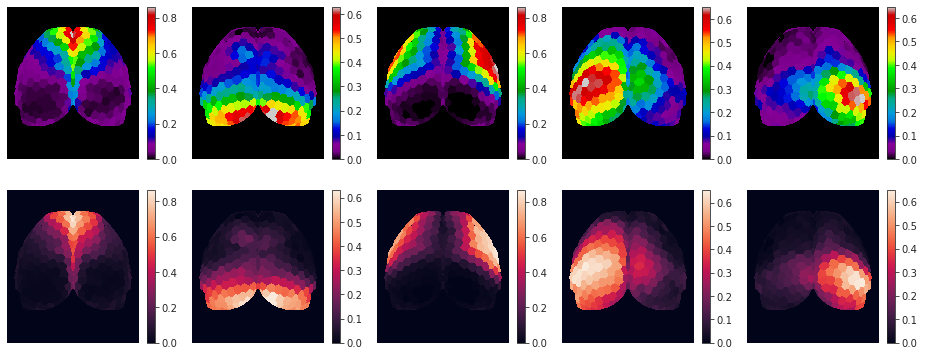

In [9]:
proj = gr.project_vec(pi_avg)

fig, axes = create_figure(2, len(pi_avg), (13, 5.5))
for i in range(len(pi_avg)):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

In [10]:
gr = Group(mice, 5, 'p15-sample', 'ca2', centroids_from='runs')#, structs2align=structs2align)

In [11]:
pi_arr, gam_arr, lam_arr = gr.fit_group()

Warning, nan in global order

In [12]:
__pi, gam, lam = tuple(map(
    lambda x: bn.nanmedian(x, -3),
    [pi_arr, gam_arr, lam_arr]
))

pi = gam / np.nansum(gam, -2, keepdims=True)
pi.shape

(10, 3, 4, 5, 302)

In [13]:
__pi_avg, pi_avg, gam_avg, lam_avg = tuple(map(
    lambda x: bn.nanmean(bn.nanmean(bn.nanmean(x, 2), 1), 0),
    [__pi, pi, gam, lam]
))

In [14]:
pi_avg.shape, np.isnan(pi_avg).sum()

((5, 302), 0)

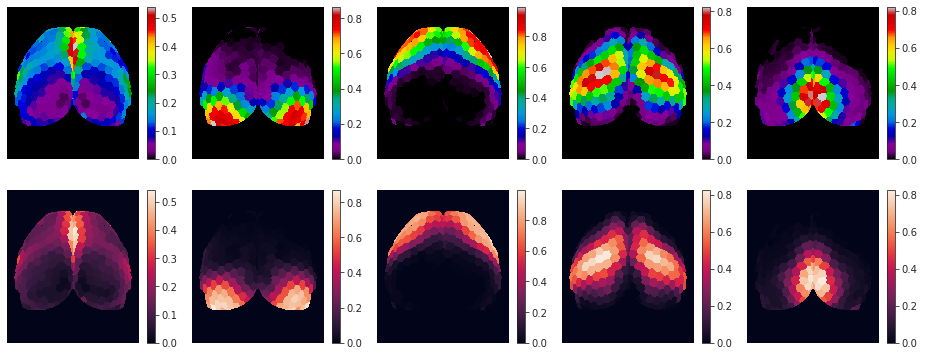

In [15]:
proj = gr.project_vec(pi_avg)

fig, axes = create_figure(2, len(pi_avg), (13, 5.5))
for i in range(len(pi_avg)):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

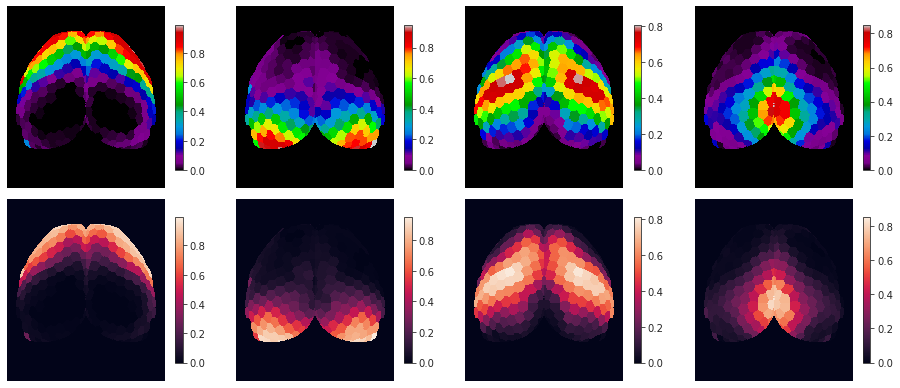

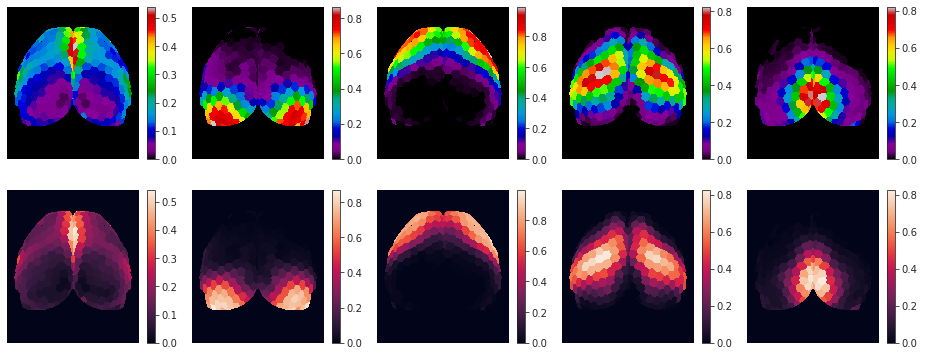

In [17]:
pi, gam, lam = bn.nanmedian(gam_arr, -3)
gam.shape

(10, 3, 4, 5, 302)

In [23]:
gam_avg = bn.nanmean(bn.nanmean(bn.nanmean(gam, 2), 1), 0)
gam_avg.shape

(5, 302)

In [24]:
np.isnan(gam_avg).sum()

0

In [25]:
pi_avg = gam_avg / np.nansum(gam_avg, 0, keepdims=True)
proj = gr.project_vec(pi_avg)

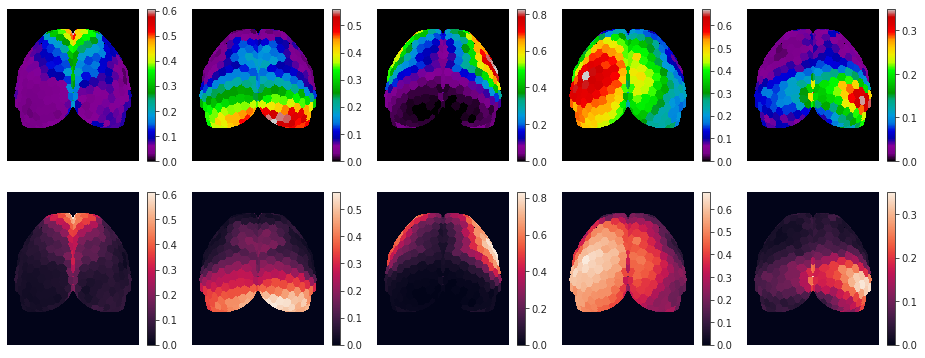

In [26]:
pi_avg = gam_avg / np.nansum(gam_avg, 0, keepdims=True)
proj = gr.project_vec(pi_avg)

fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

In [32]:
pi_avg_2, gam_avg_2 = [], []
for k, sv in svinets.items():
    if sv is None:
        print('vay dada')
    if mice.looper[k][-1] > 0:
        gam_avg_2.append(np.expand_dims(sv.gam, 0))
        pi_avg_2.append(np.expand_dims(sv.pi, 0))

In [33]:
pi_avg_2 = np.concatenate(pi_avg_2)
gam_avg_2 = np.concatenate(gam_avg_2)
pi_avg_2.shape, gam_avg_2.shape

((114, 5, 302), (114, 5, 302))

In [34]:
pi_avg_2 = bn.nanmean(pi_avg_2, 0)
gam_avg_2 = bn.nanmean(gam_avg_2, 0)

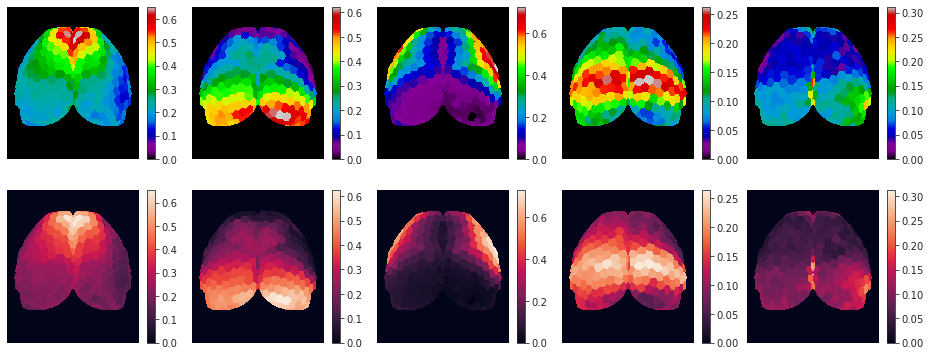

In [38]:
proj = gr.project_vec(pi_avg_2)

fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

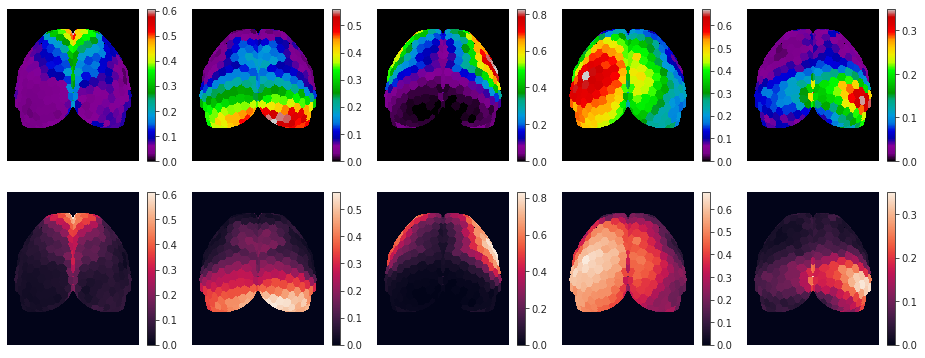

In [35]:
pi_avg = gam_avg / np.nansum(gam_avg, 0, keepdims=True)
proj = gr.project_vec(pi_avg)

fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

In [9]:
len(nonan), centroids.shape

(281, (5, 302))

In [10]:
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=len(which_clusters),
    match_metric='euclidean',
    random_state=self.mice.cfg.random_state,
    normalize=True,
)
centroids[:, nonan] = _centroids

In [11]:
list(which_clusters) != list(range(self.num_k))

False

In [15]:
pi = centroids / np.nansum(centroids, 0, keepdims=True)
proj = gr.project_vec(pi)

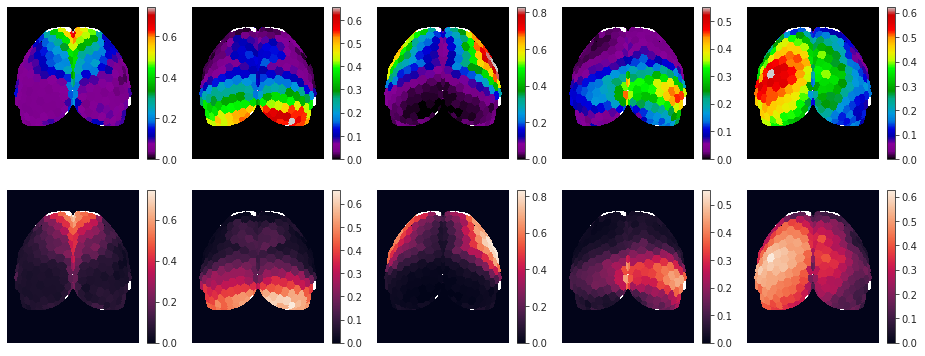

In [16]:
fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

In [17]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=pi,
    dist_metric=self.dist_metric,
    global_order=self.global_order,
)

In [18]:
global_mapping

[0, 1, 2, 4, 3]

In [19]:
centroids = centroids[global_mapping]

In [20]:
pi = centroids / np.nansum(centroids, 0, keepdims=True)
proj = gr.project_vec(pi)

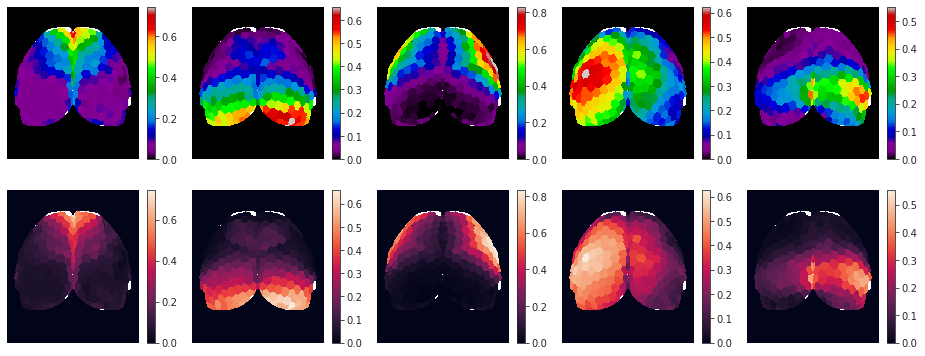

In [21]:
fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

In [22]:
ner = Normalizer()

In [23]:
xxx = ner.fit_transform(centroids[:, nonan])

In [26]:
for k, g in gammas.items():
    try:
        ner.fit_transform(g[:, nonan])
    except:
        print(k)

sub-SLC08_ses-3

sub-SLC08

In [27]:
g = gammas['sub-SLC08_ses-3']
g.shape

(5, 302)

In [32]:
np.where(np.isnan(g).sum(0))[0]

array([131, 143, 150])

In [48]:
data_clean = {}
for k, g in gammas.items():
    _g = g[:, nonan]
    _g = np.where(~np.isnan(_g), _g, 0.0)
    try:
        data_clean[k] = ner.fit_transform(_g)
    except:
        print(k)
        break

In [50]:
proj = gr.project_vec(data_clean['sub-SLC'])

fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

IndexError: index 281 is out of bounds for axis 0 with size 281

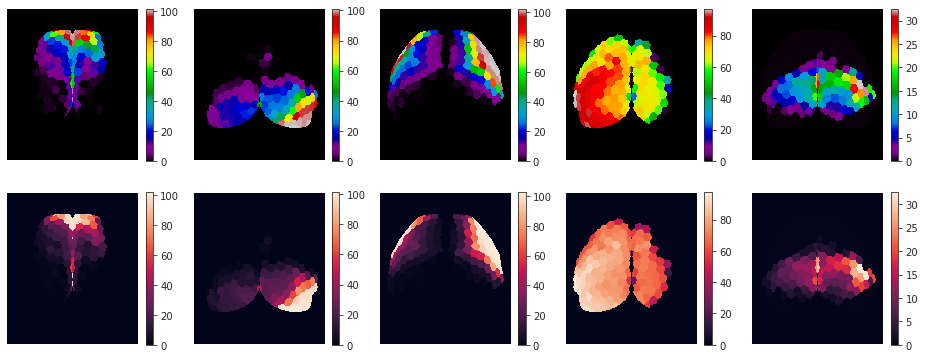

In [39]:
proj = gr.project_vec(svinets['sub-SLC'].gam)

fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [5]:
svinets, perms, centroids = gr.align_group()

  0%|          | 0/160 [00:00<?, ?it/s]

In [6]:
perms

{
    'sub-SLC01_ses-1_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-1_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-1_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-1_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-2_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-2_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-2_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-2_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-3_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-3_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-3_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC01_ses-3_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-1_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-1_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-1_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-1_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-2_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-2_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-2_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-3_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-3_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-3_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC02_ses-3_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-1_run-2': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-1_run-4': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-1_run-6': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-2_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-2_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-2_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-2_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-3_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-3_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-3_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC03_ses-3_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-1_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-1_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-1_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-1_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-2_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-2_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-2_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-2_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-3_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-3_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-3_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC04_ses-3_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-1_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-1_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-1_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-2_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-2_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-2_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-2_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-3_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-3_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-3_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC05_ses-3_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-1_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-1_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-1_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-1_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-2_run-1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-2_run-3': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-2_run-5': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-2_run-7': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    'sub-SLC06_ses-3_run-1': {0: 

In [7]:
centroids.shape

(5, 302)

[
    <matplotlib.lines.Line2D object at 0x7f6232b5fa60>,
    <matplotlib.lines.Line2D object at 0x7f6232b5f9d0>,
    <matplotlib.lines.Line2D object at 0x7f6232b5fb50>,
    <matplotlib.lines.Line2D object at 0x7f6232b5fc10>,
    <matplotlib.lines.Line2D object at 0x7f6232b5fcd0>
]

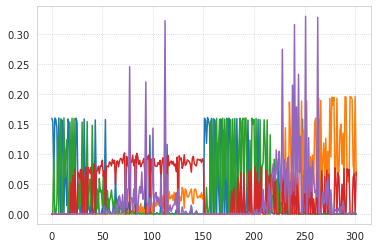

In [8]:
plt.plot(centroids.T)

In [9]:
pi = centroids / np.nansum(centroids, 0, keepdims=True)

[
    <matplotlib.lines.Line2D object at 0x7f62cf040790>,
    <matplotlib.lines.Line2D object at 0x7f62cf040a00>,
    <matplotlib.lines.Line2D object at 0x7f62cf040580>,
    <matplotlib.lines.Line2D object at 0x7f62cf040520>,
    <matplotlib.lines.Line2D object at 0x7f62cf040160>
]

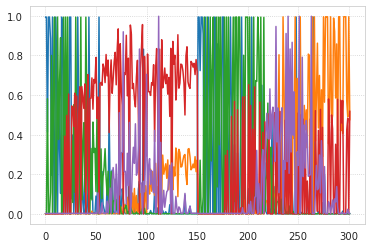

In [10]:
plt.plot(pi.T)

In [11]:
proj = gr.project_vec(pi)

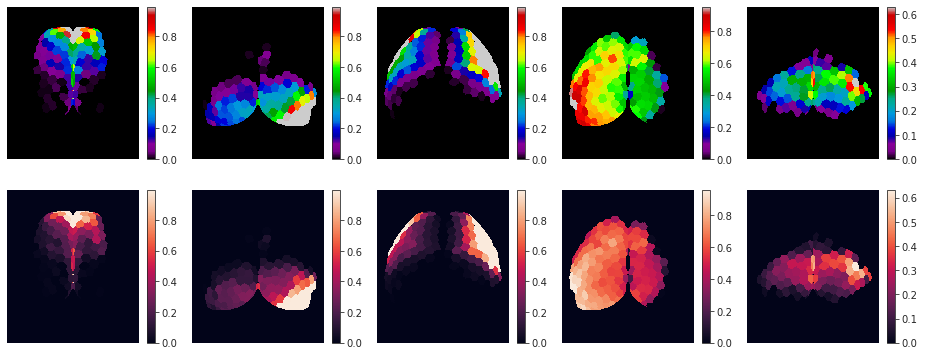

In [14]:
fig, axes = create_figure(2, 5, (13, 5.5))
for i in range(5):
    ax = axes[0, i]
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax = axes[1, i]
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
remove_ticks(axes)
plt.show()

In [17]:
self = gr

In [22]:
seed_counts = []
for sv in svinets.values():
    seed_counts.append(len(sv.gam_all))

meta_key = f"{self.mode.split('-')[0]}_{self.task}"
run_counts = []
for key, (sub, ses, _) in self.mice.looper_agg.items():
    if sub == -1 or ses == -1:
        continue
    run_counts.append(len(
        self.mice.combine_meta[meta_key][key]
    ))
run_counts = collections.Counter(run_counts)
rng = get_rng(self.mice.cfg.random_state)

In [23]:
run_counts

Counter({4: 25, 3: 4, 2: 1})

In [24]:
collections.Counter(seed_counts).most_common()

[(980, 160)]

In [25]:
sv.gam_all.shape

(980, 5, 302)

In [4]:
pi_avg = []
for key in tqdm(mice.ca):
    if 'run' not in key:
        continue
    sv = SVINET(mice, 5, 'p40-sample', key, 'ca2', metric='pearson', verbose=False)
    _ = sv.load_results()
    if sv.pi is not None:
        pi_avg.append(np.expand_dims(sv.pi, axis=0))
    # proj = sv.project_vec()
    
    # fig, axes = create_figure(1, 5, (13, 3.))
    # for i, ax in enumerate(axes.flat):
    #     im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    #     plt.colorbar(im, ax=ax, shrink=0.8)
    # fig.suptitle(key, fontsize=14)
    # remove_ticks(axes)
    # plt.show()

  0%|          | 0/162 [00:00<?, ?it/s]

In [5]:
pi_avg = np.concatenate(pi_avg)
pi_avg.shape

(118, 5, 302)

In [6]:
pi_ca_runs = np.nanmean(pi_avg, 0)

In [7]:
proj = sv.project_vec(pi_ca_runs)

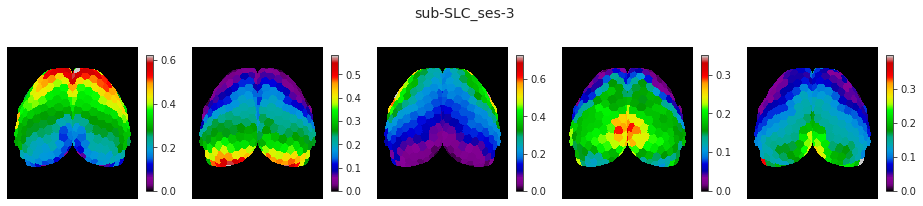

In [8]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

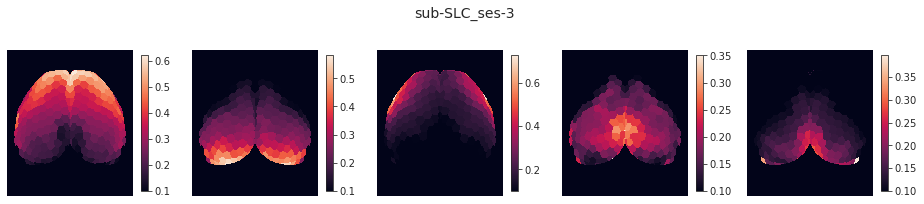

In [9]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i], vmin=0.1)
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

<matplotlib.image.AxesImage object at 0x7f4fe5afd250>

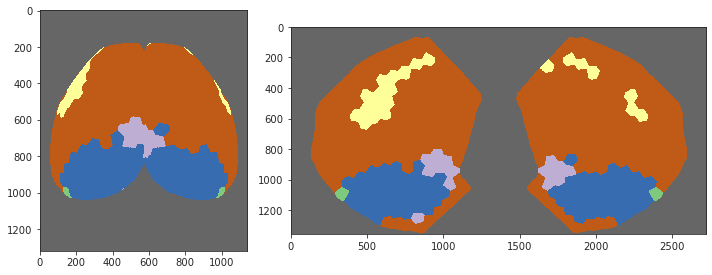

In [10]:
fig, axes = create_figure(1, 2, (10, 4), gridspec_kw={'width_ratios': [1, 2]})

x_ca_runs = np.nanargmax(proj['parcel2d-top'], axis=0)
x_ca_runs.flat[mice.parcel['nonzero-idxs_parcel2d-top']] += 1
axes[0].imshow(x_ca_runs, cmap='Accent_r')

y_ca_runs = np.nanargmax(proj['parcel2d-flat'], axis=0)
y_ca_runs.flat[mice.parcel['nonzero-idxs_parcel2d-flat']] += 1
axes[1].imshow(y_ca_runs, cmap='Accent_r')

In [11]:
pi_avg = []
for key in tqdm(mice.ca):
    sub, ses, run = mice.looper[key]
    if sub == -1 or ses == -1 or run != -1:
        continue
    sv = SVINET(mice, 5, 'p40-sample', key, 'ca2', metric='pearson', verbose=False)
    _ = sv.load_results()
    if sv.pi is not None:
        pi_avg.append(np.expand_dims(sv.pi, axis=0))
    # proj = sv.project_vec()
    
    # fig, axes = create_figure(1, 5, (13, 3.))
    # for i, ax in enumerate(axes.flat):
    #     im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    #     plt.colorbar(im, ax=ax, shrink=0.8)
    # fig.suptitle(key, fontsize=14)
    # remove_ticks(axes)
    # plt.show()

  0%|          | 0/162 [00:00<?, ?it/s]

In [12]:
pi_avg = np.concatenate(pi_avg)
pi_avg.shape

(30, 5, 302)

In [13]:
pi_ca_sess = np.nanmean(pi_avg, 0)

In [14]:
proj = sv.project_vec(pi_ca_sess)

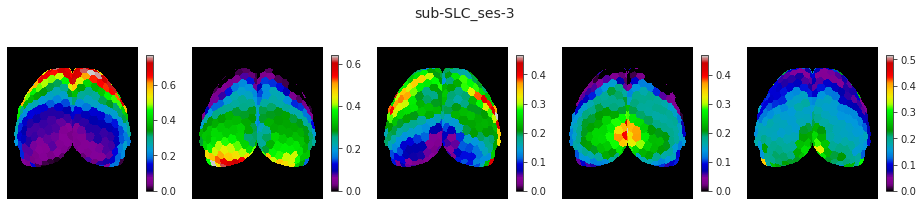

In [15]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

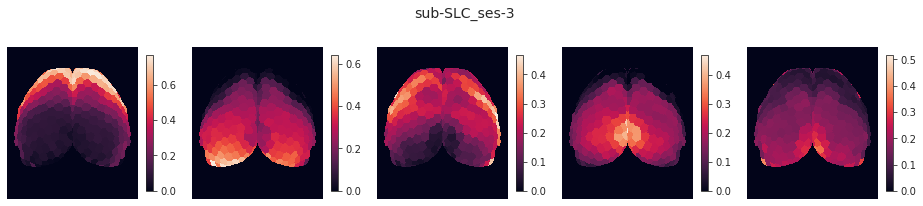

In [16]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i])
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

<matplotlib.image.AxesImage object at 0x7f4fe55514c0>

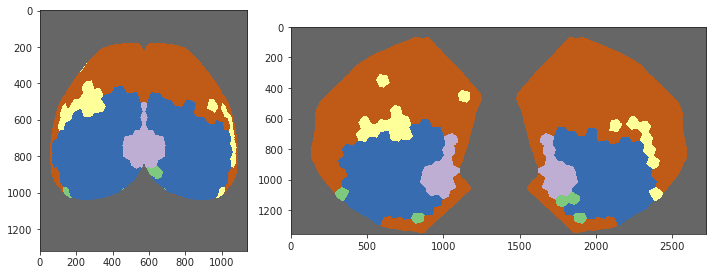

In [17]:
fig, axes = create_figure(1, 2, (10, 4), gridspec_kw={'width_ratios': [1, 2]})

x_ca_sess = np.nanargmax(proj['parcel2d-top'], axis=0)
x_ca_sess.flat[mice.parcel['nonzero-idxs_parcel2d-top']] += 1
axes[0].imshow(x_ca_sess, cmap='Accent_r')

y_ca_sess = np.nanargmax(proj['parcel2d-flat'], axis=0)
y_ca_sess.flat[mice.parcel['nonzero-idxs_parcel2d-flat']] += 1
axes[1].imshow(y_ca_sess, cmap='Accent_r')

In [18]:
pi_avg = []
for key in tqdm(mice.bold):
    if 'run' not in key:
        continue
    sv = SVINET(mice, 5, 'p40-sample', key, 'bold-lite', metric='pearson', verbose=False)
    _ = sv.load_results()
    if sv.pi is not None:
        pi_avg.append(np.expand_dims(sv.pi, axis=0))
    # proj = sv.project_vec()
    
    # fig, axes = create_figure(1, 5, (13, 3.))
    # for i, ax in enumerate(axes.flat):
    #     im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    #     plt.colorbar(im, ax=ax, shrink=0.8)
    # fig.suptitle(key, fontsize=14)
    # remove_ticks(axes)
    # plt.show()

  0%|          | 0/160 [00:00<?, ?it/s]

Warning, fits dir is empty

Warning, fits dir is empty

In [19]:
pi_avg = np.concatenate(pi_avg)
pi_avg.shape

(114, 5, 302)

In [20]:
pi_bl_runs = np.nanmean(pi_avg, 0)

In [21]:
proj = sv.project_vec(pi_bl_runs)

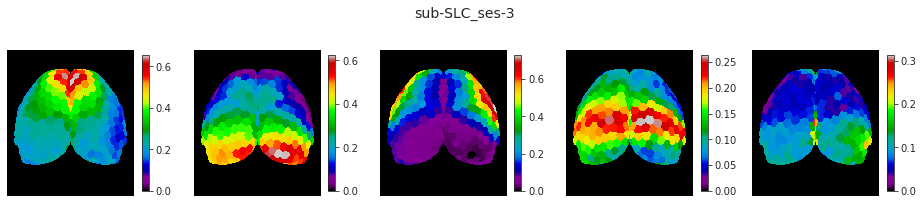

In [22]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

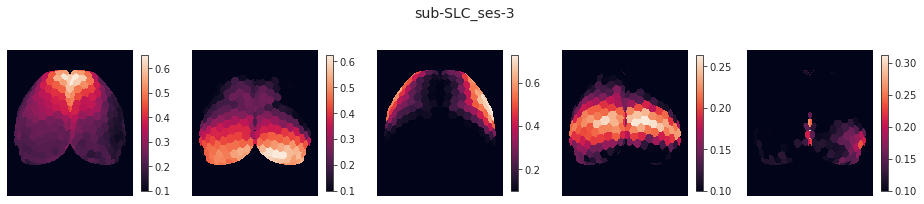

In [23]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i], vmin=0.1)
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

<matplotlib.image.AxesImage object at 0x7f4fe5f78d60>

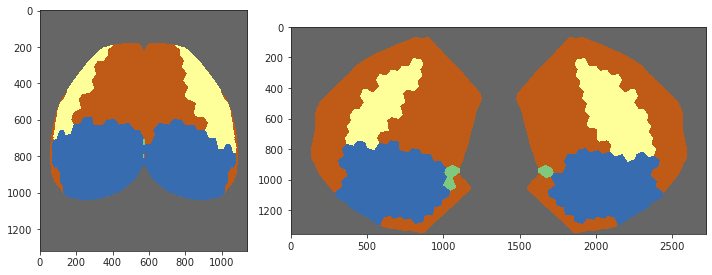

In [24]:
fig, axes = create_figure(1, 2, (10, 4), gridspec_kw={'width_ratios': [1, 2]})

x_bl_runs = np.nanargmax(proj['parcel2d-top'], axis=0)
x_bl_runs.flat[mice.parcel['nonzero-idxs_parcel2d-top']] += 1
axes[0].imshow(x_bl_runs, cmap='Accent_r')

y_bl_runs = np.nanargmax(proj['parcel2d-flat'], axis=0)
y_bl_runs.flat[mice.parcel['nonzero-idxs_parcel2d-flat']] += 1
axes[1].imshow(y_bl_runs, cmap='Accent_r')

In [25]:
pi_avg = []
for key in tqdm(mice.bold):
    sub, ses, run = mice.looper[key]
    if sub == -1 or ses == -1 or run != -1:
        continue
    sv = SVINET(mice, 5, 'p40-sample', key, 'bold-lite', metric='pearson', verbose=False)
    _ = sv.load_results()
    if sv.pi is not None:
        pi_avg.append(np.expand_dims(sv.pi, axis=0))
    # proj = sv.project_vec()
    
    # fig, axes = create_figure(1, 5, (13, 3.))
    # for i, ax in enumerate(axes.flat):
    #     im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    #     plt.colorbar(im, ax=ax, shrink=0.8)
    # fig.suptitle(key, fontsize=14)
    # remove_ticks(axes)
    # plt.show()

  0%|          | 0/160 [00:00<?, ?it/s]

In [26]:
pi_avg = np.concatenate(pi_avg)
pi_avg.shape

(30, 5, 302)

In [27]:
pi_bl_sess = np.nanmean(pi_avg, 0)

In [28]:
proj = sv.project_vec(pi_bl_sess)

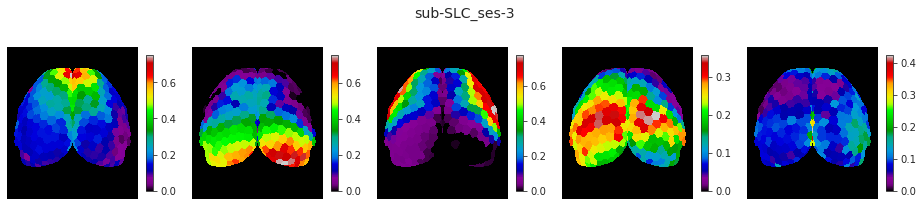

In [29]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i], cmap='nipy_spectral')
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

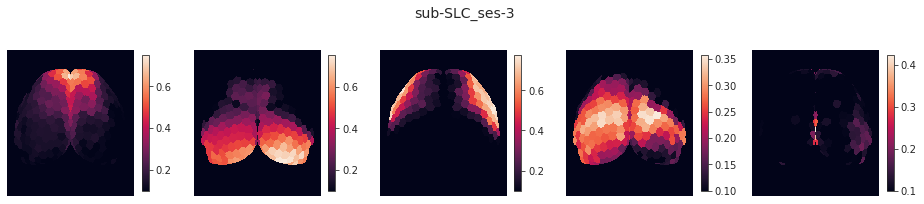

In [30]:
fig, axes = create_figure(1, 5, (13, 3.))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(proj['parcel2d-top'][i], vmin=0.1)
    plt.colorbar(im, ax=ax, shrink=0.8)
fig.suptitle(key, fontsize=14)
remove_ticks(axes)
plt.show()

<matplotlib.image.AxesImage object at 0x7f4fe56755b0>

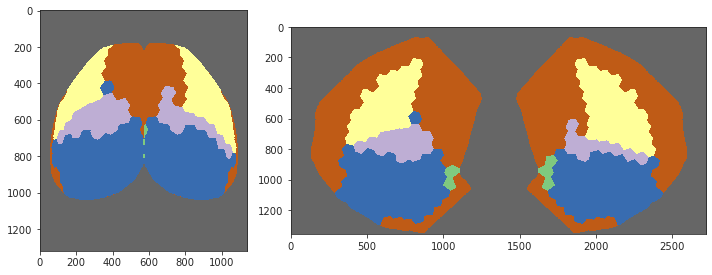

In [31]:
fig, axes = create_figure(1, 2, (10, 4), gridspec_kw={'width_ratios': [1, 2]})

x_bl_sess = np.nanargmax(proj['parcel2d-top'], axis=0)
x_bl_sess.flat[mice.parcel['nonzero-idxs_parcel2d-top']] += 1
axes[0].imshow(x_bl_sess, cmap='Accent_r')

y_bl_sess = np.nanargmax(proj['parcel2d-flat'], axis=0)
y_bl_sess.flat[mice.parcel['nonzero-idxs_parcel2d-flat']] += 1
axes[1].imshow(y_bl_sess, cmap='Accent_r')

In [32]:
d = sp_dist.cdist(pi_ca_runs, pi_ca_sess, metric='cosine')
sim = dist2sim(d)

<matplotlib.colorbar.Colorbar object at 0x7f4fe52de520>

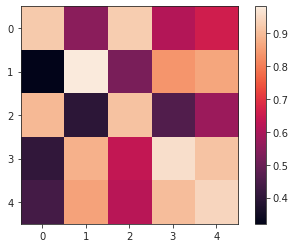

In [33]:
plt.imshow(sim)
plt.colorbar()

In [34]:
np.diag(sim)

array([0.92393911, 0.9826448 , 0.91149122, 0.96107837, 0.94567248])

<matplotlib.colorbar.Colorbar object at 0x7f4fe4752880>

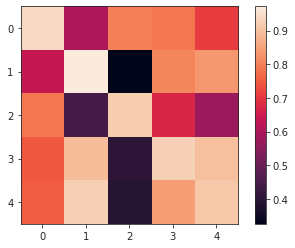

In [55]:
d = sp_dist.cdist(pi_ca_runs, pi_bl_runs, metric='cosine')
sim = dist2sim(d)

plt.imshow(sim)
plt.colorbar()

In [56]:
np.diag(sim), np.diag(sim).mean()

(
    array([0.93938741, 0.97217728, 0.92158353, 0.92783819, 0.90999917]),
    0.9341971171773128
)

<matplotlib.colorbar.Colorbar object at 0x7f4fe4679310>

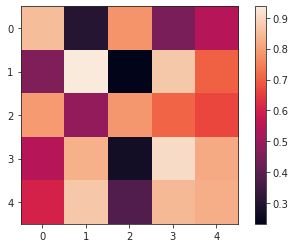

In [57]:
d = sp_dist.cdist(pi_ca_sess, pi_bl_sess, metric='cosine')
sim = dist2sim(d)

plt.imshow(sim)
plt.colorbar()

In [58]:
np.diag(sim), np.diag(sim).mean()

(
    array([0.85428295, 0.93676213, 0.78589216, 0.90661681, 0.82679314]),
    0.8620694371618273
)

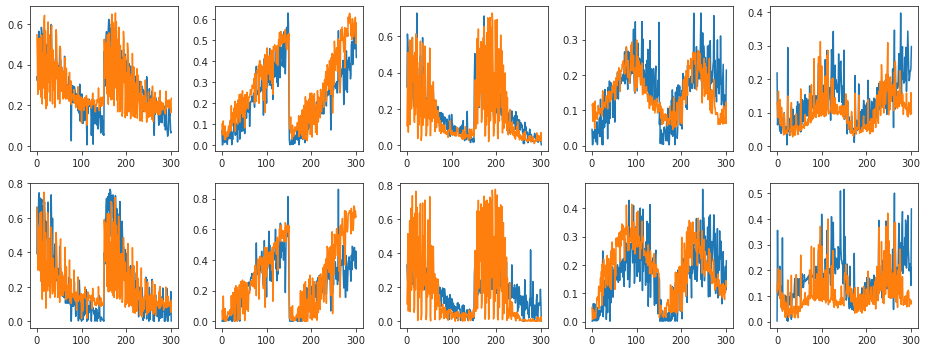

In [59]:
fig, axes = create_figure(2, 5, (13, 5))

for i in range(5):
    ax = axes[0, i]
    ax.plot(pi_ca_runs[i])
    ax.plot(pi_bl_runs[i])
    
    ax = axes[1, i]
    ax.plot(pi_ca_sess[i])
    ax.plot(pi_bl_sess[i])
plt.show()

<matplotlib.image.AxesImage object at 0x7f4fe42c1670>

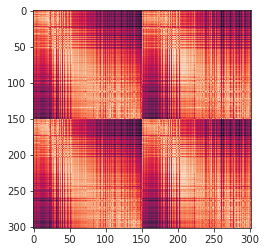

In [60]:
d = sp_dist.cdist(pi_ca_runs.T, pi_ca_sess.T, metric='jensenshannon')
sim_same = dist2sim(d)
plt.imshow(sim_same)

<matplotlib.image.AxesImage object at 0x7f4fe4218dc0>

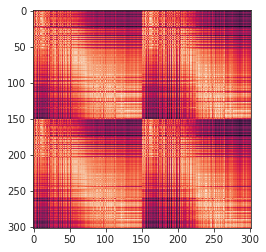

In [61]:
d = sp_dist.cdist(pi_ca_runs.T, pi_bl_runs.T, metric='jensenshannon')
sim_across = dist2sim(d)
plt.imshow(sim_across)

<AxesSubplot:ylabel='Count'>

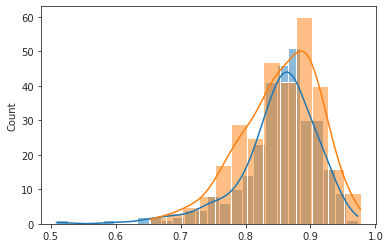

In [62]:
sns.histplot(np.diag(sim_same), kde=True)
sns.histplot(np.diag(sim_across), color='C1', kde=True)

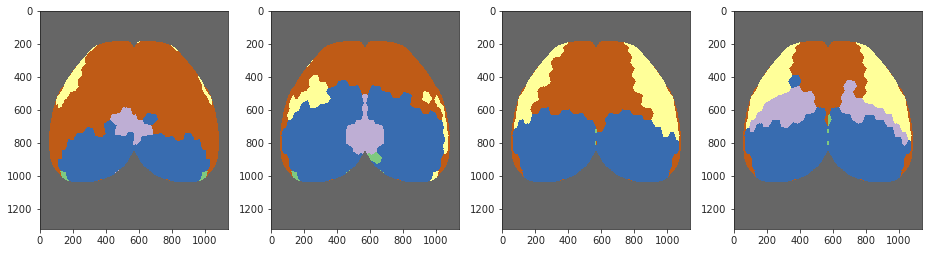

In [64]:
fig, axes = create_figure(1, 4, (13, 4))

axes[0].imshow(x_ca_runs, cmap='Accent_r')
axes[1].imshow(x_ca_sess, cmap='Accent_r')
axes[2].imshow(x_bl_runs, cmap='Accent_r')
axes[3].imshow(x_bl_sess, cmap='Accent_r')
plt.show()

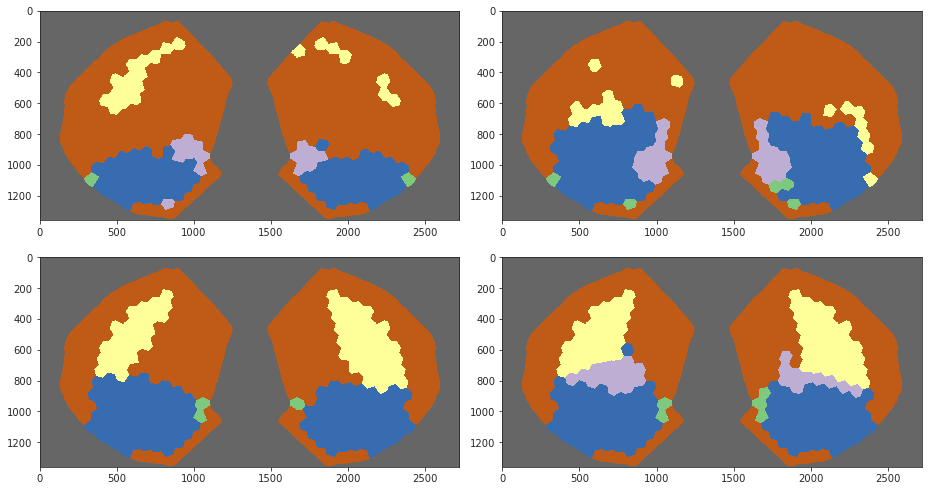

In [66]:
fig, axes = create_figure(2, 2, (13, 7))

axes.flat[0].imshow(y_ca_runs, cmap='Accent_r')
axes.flat[1].imshow(y_ca_sess, cmap='Accent_r')
axes.flat[2].imshow(y_bl_runs, cmap='Accent_r')
axes.flat[3].imshow(y_bl_sess, cmap='Accent_r')
plt.show()

In [4]:
gr = Group(mice, 5, 'p30-sample')

In [8]:
len(range(10))

10

In [9]:
np.delete(range(10), range(6, 10))

array([0, 1, 2, 3, 4, 5])

In [16]:
collections.Counter([1, 1, 1, 2,2])

1

In [4]:
sv = SVINET(mice, 5, 'p40-sample', 'sub-SLC', 'bold-lite', metric='pearson')

current expt: 'p40-sample'

In [5]:
_ = sv.load_results()

Warning, fits dir is empty

In [13]:
sv.path

In [8]:
sv.create_path(['test', 'hier'])

'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-192*4/results/SVINET/n-192*4_bold-lite_rest_pearson_sub-SLC/test-hier-(2021_10_23)'

In [9]:
hier = Hierarchical(mice)

In [10]:
hier.create_path(['test', 'hier'])

'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-192*4/results/Hierarchical/n-192*4_bold_rest_correlation_sub-SLC/test-hier-(2021_10_23)'

In [21]:
proj = sv.project_vec()

In [22]:
list(proj)

['parcel2d-top', 'parcel2d-flat', 'parcel3d']

<matplotlib.image.AxesImage object at 0x7f449f7c9550>

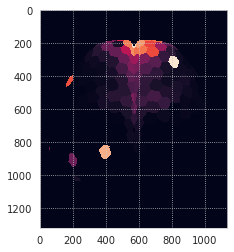

In [39]:
x = proj['parcel2d-top'][0].copy()
x[np.isnan(x)] = 0.0
plt.imshow(x)

[<matplotlib.lines.Line2D object at 0x7f44a0037940>]

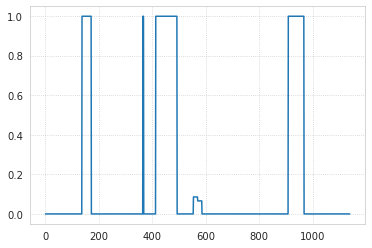

In [35]:
plt.plot(x[600])

In [43]:
y = mice.al.cortical_map(proj['parcel3d'][-1], 'top_view', np.nanmean)

In [44]:
y.shape

(1320, 1140)

<matplotlib.image.AxesImage object at 0x7f449f928640>

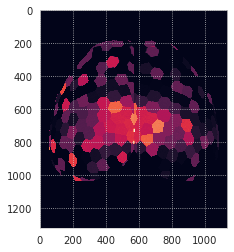

In [45]:
plt.imshow(y)

In [15]:
sv._create_save_dir()

'SVINET'

In [16]:
sv.path

'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-192*4/results/SVINET/n-192*4_bold-lite_rest_pearson_sub-SLC/real-k5-p40-sample-euclidean-linksampling-(2021_10_23)'

In [18]:
sv.path.replace(sv.perc, 'p88-binary')

'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-192*4/results/SVINET/n-192*4_bold-lite_rest_pearson_sub-SLC/real-k5-p88-binary-euclidean-linksampling-(2021_10_23)'

In [19]:
sv.path

'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-192*4/results/SVINET/n-192*4_bold-lite_rest_pearson_sub-SLC/real-k5-p40-sample-euclidean-linksampling-(2021_10_23)'

In [82]:
sv = SVINET(mice, 6, 'p40-sample', 'sub-SLC', 'bold', metric='spearman')

current expt: 'p40-sample'

In [83]:
_ = sv.load_runs()

[PROGRESS] experiment loaded: 'k = 6, p40-sample',  total # runs:  500

In [53]:
sv.pi.shape

(6, 1742)

[
    <matplotlib.lines.Line2D object at 0x7f44a060ffa0>,
    <matplotlib.lines.Line2D object at 0x7f44a060f9d0>,
    <matplotlib.lines.Line2D object at 0x7f44a060ff40>,
    <matplotlib.lines.Line2D object at 0x7f44a0643640>,
    <matplotlib.lines.Line2D object at 0x7f44a0643e20>,
    <matplotlib.lines.Line2D object at 0x7f44a01122b0>
]

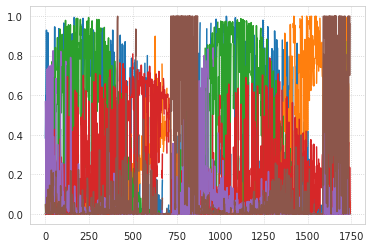

In [54]:
plt.plot(sv.pi.T)

In [55]:
proj = sv.project_vec()

In [56]:
list(proj)

['parcel2d-top', 'parcel2d-flat', 'parcel3d']

<AxesSubplot:ylabel='Count'>

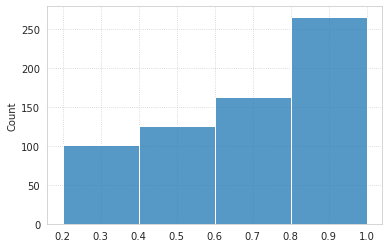

In [69]:
sns.histplot(np.round(sv.pi[2], 2), bins=np.linspace(0.2, 1.0, 5))

<matplotlib.colorbar.Colorbar object at 0x7f4328c21760>

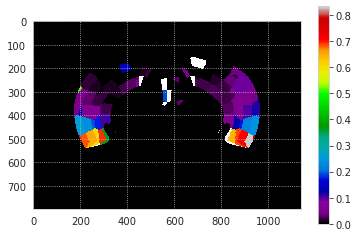

In [76]:
plt.imshow(proj['parcel3d'][4][400], cmap='nipy_spectral')
plt.colorbar()

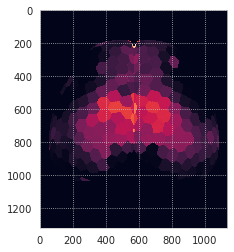

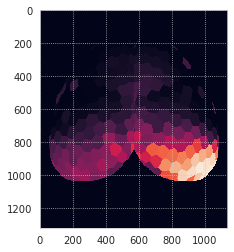

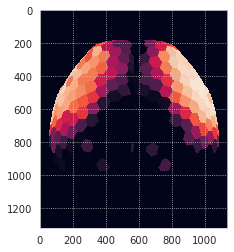

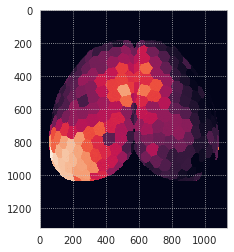

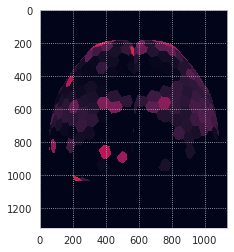

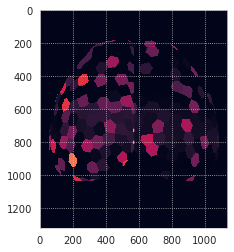

In [79]:
for i in range(sv.num_k):
    y = mice.al.cortical_map(proj['parcel3d'][i], 'top_view', np.nanmean)
    plt.imshow(y)
    plt.show()

In [122]:
key = 'sub-SLC10_ses-2_run-3'
net = Network(mice, key, 'bold-lite', metric='spearman')

In [87]:
net.fit_network()

[PROGRESS] fit: initiated

TypeError: 'float' object does not support item assignment

In [90]:
net.data.shape

(302, 550)

<matplotlib.image.AxesImage object at 0x7f4486ff1fa0>

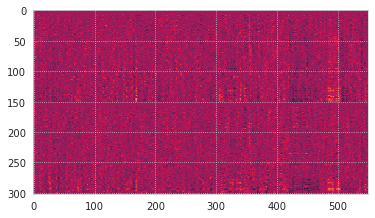

In [91]:
plt.imshow(net.data)

In [101]:
a, p = sp_stats.spearmanr(net.data, axis=1)
a, p 

(nan, nan)

In [100]:
a.shape

(550, 550)

[<matplotlib.lines.Line2D object at 0x7f448657b3a0>]

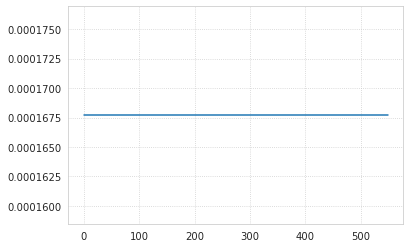

In [109]:
plt.plot(net.data[2])

<matplotlib.lines.Line2D object at 0x7f4483d1a2e0>

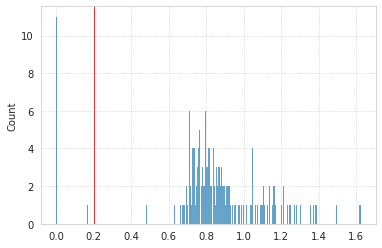

In [132]:
sns.histplot(np.std(net.data, axis=1), bins=500)
plt.axvline(0.2, lw=0.8, color='r')

<matplotlib.lines.Line2D object at 0x7f4484c43c40>

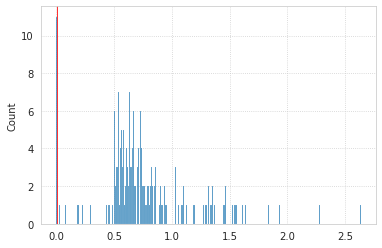

In [131]:
sns.histplot(np.var(net.data, axis=1), bins=500)
plt.axvline(0.01, lw=0.8, color='r')

(0.0, 0.1)

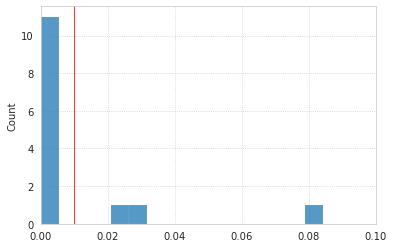

In [133]:
sns.histplot(np.var(net.data, axis=1), bins=500)
plt.axvline(0.01, lw=0.8, color='r')
plt.xlim(0., .1)

In [114]:
net.data[np.std(net.data, axis=1) < 1e-5] = np.nan

In [117]:
a, p = sp_stats.spearmanr(net.data, axis=1)

<matplotlib.image.AxesImage object at 0x7f4486555df0>

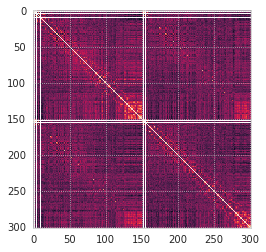

In [118]:
plt.imshow(a)

In [134]:
key = 'sub-SLC10_ses-2_run-3'
net = Network(mice, key, 'ca2', metric='spearman')

<matplotlib.lines.Line2D object at 0x7f44836dd1f0>

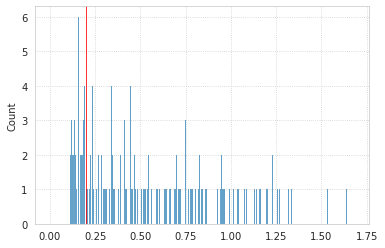

In [135]:
sns.histplot(np.std(net.data, axis=1), bins=500)
plt.axvline(0.2, lw=0.8, color='r')

<matplotlib.lines.Line2D object at 0x7f44835dbe80>

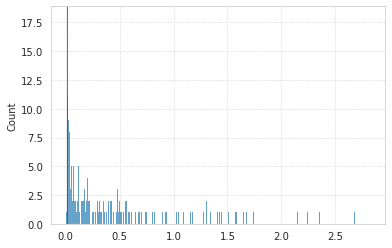

In [136]:
sns.histplot(np.var(net.data, axis=1), bins=500)
plt.axvline(0.01, lw=0.8, color='r')

(0.0, 0.1)

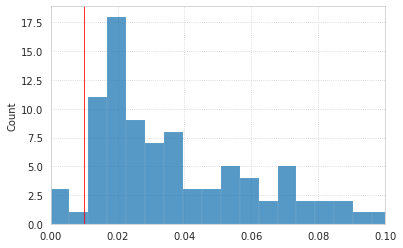

In [139]:
sns.histplot(np.var(net.data, axis=1), bins=500)
plt.axvline(0.01, lw=0.8, color='r')
plt.xlim(0., .1)

In [147]:
eps = 1e-3


3